# Modeling de Cancer de Mama

Se prueban inicialmente bajo un train/validation/split los modelos de:

Ahora iniciaremos con modelos de arboles

  * CART

  * ID3

Y ejecutaremos los visto en la clase anterior

  * Regresión Logística

  * Knn

In [3]:
# Upload your kaggle.json file (contains API key)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andrescanol","key":"9e75d255bd964e28bccf0503248b98e3"}'}

In [4]:
# Make directory and move kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c aa-ii-2025-i-modelos-tradicionales-ca-mama

!unzip aa-ii-2025-i-modelos-tradicionales-ca-mama.zip

aa-ii-2025-i-modelos-tradicionales-ca-mama.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  aa-ii-2025-i-modelos-tradicionales-ca-mama.zip
replace Diccionario.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Diccionario.xlsx        
replace df_test.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: df_test.parquet         
replace df_train.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: df_train.parquet        
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   


## Importamos Librerias

In [5]:
import numpy as np  # Algebra lineal, manipulación de arreglos numéricos.
import pandas as pd  # Procesamiento de datos, lectura/escritura de archivos CSV.
import os.path as osp  # Manejo de rutas de archivos.
import pickle  # Serialización y deserialización de objetos Python (guardar/cargar modelos).


# Modelos de clasificación Adicional

from sklearn import tree

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression  # Modelo de regresión logística para clasificación binaria.
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors (KNN) para clasificación basada en distancia.
from sklearn.naive_bayes import GaussianNB  # Clasificador Naive Bayes basado en distribución Gaussiana.

# Preprocesamiento de datos
from sklearn.preprocessing import OneHotEncoder  # Codificación one-hot para variables categóricas nominales.
from sklearn.preprocessing import OrdinalEncoder  # Codificación ordinal para variables categóricas con orden.
from sklearn.preprocessing import StandardScaler  # Normalización de datos para mejorar el rendimiento del modelo.
from sklearn.preprocessing import FunctionTransformer  # Aplicación de transformaciones personalizadas.

# División del conjunto de datos
from sklearn.model_selection import train_test_split  # División en conjunto de entrenamiento y prueba.

# Selección de características
from sklearn.feature_selection import VarianceThreshold  # Elimina características con varianza baja (irrelevantes).
from sklearn.feature_selection import SelectPercentile, chi2  # Selección de características más relevantes con Chi-cuadrado.

# Construcción del pipeline de procesamiento y modelado
from sklearn.compose import ColumnTransformer  # Aplica transformaciones específicas a diferentes columnas.
from sklearn.pipeline import Pipeline, make_pipeline  # Automatiza el flujo de preprocesamiento y modelado.

# Manejo de valores faltantes
from sklearn.impute import SimpleImputer  # Rellena valores faltantes con media, mediana, moda, etc.

# Evaluación de modelos
import sklearn.metrics as skm  # Métricas de rendimiento como precisión, recall, F1-score, AUC-ROC, etc.

# Visualización de datos
import matplotlib.pyplot as plt  # Gráficos y visualización de métricas.
import seaborn as sns  # Visualización avanzada con gráficos estadísticos.

# Medición de tiempos de ejecución
from time import time  # Captura de tiempo de inicio y fin de ejecución.
from datetime import timedelta  # Cálculo de diferencias de tiempo en ejecución.

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Funciones útiles

In [6]:
def get_imbalaced_metrics(y_true, y_preds):
    '''calcula métricas de evaluación para modelos de clasificación cuando los datos están desbalanceados.'''
    ths = np.linspace(0, 1, 1000)
    best_th = ths[
        np.argmax([skm.f1_score(y_true, y_preds>th) for th in ths])
    ]

    roc_auc = skm.roc_auc_score(y_true, y_preds)
    average_precision = skm.average_precision_score(y_true, y_preds)
    max_f1 = skm.f1_score(y_true, y_preds>best_th)
    accuracy_on_max_f1 = skm.accuracy_score(y_true, y_preds>best_th)
    kappa = skm.cohen_kappa_score(y_true, y_preds>best_th)
    baseline=y_true.value_counts(True)


    return dict(
        roc_auc=roc_auc,
        average_precision=average_precision,
        max_f1=max_f1,
        accuracy_on_max_f1=accuracy_on_max_f1,
        kappa=kappa,
        baseline=baseline.iloc[0],
        best_th = best_th
    )

## Carga de Datos

Este fragmento de código carga los datos del conjunto de entrenamiento (df_train.parquet) desde un directorio en Kaggle.

In [7]:
#DATA_DIR = "/kaggle/input/fa-i-2025-i-modelos-tradicionales-ca-mama/"
df = pd.read_parquet("df_train.parquet")
df.head()

,GENERO,ESTADO_CIVIL,FECHA_NACIMIENTO,CODIGO_SEDE,MULTI_CANCER,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,...,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,Citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion
ID,,,,,,,,,,,,,,,,,,,,,
2987,F,SO,1977-01-17,1051,None,0,2.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion
3423,F,CA,1980-10-13,1028,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,Sin servicios nutricion
6981,F,SO,1951-10-28,1022,None,0,3.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Una servicio nutricion
6701,F,SO,1984-03-31,1026,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,Sin servicios nutricion
7361,F,UL,1974-03-28,1007,None,0,1.0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,Sin servicios nutricion


Separamos las características (X) y la variable objetivo (y) del conjunto de datos, y luego analiza el balance de clases en la variable objetivo. Del EDA realizado anteriormente ya sabiamos del desbalanceo de nuestra variable objetivo, un 11% de complicaciones.

In [8]:
X, y = df.drop(columns="Target"), df["Target"]
y.value_counts(True) * 100

,proportion
Target,
0.0,88.697851
1.0,11.302149


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3955 entries, 2987 to 898
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[us]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                337 non-null    object        
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_DATOS_PESO_TALLA      3955 non-null   datetime64[us]


Calculamos la edad de los pacientes al momento de la complicación o corte del analisis.

In [10]:
X['EDAD_COMPLICACION'] = (X['Fecha_cero'] - X['FECHA_NACIMIENTO']).dt.days // 365

Validamos las variables que tienen mucha nulidad ¿La quitamos? o que nos dice el negocio? Esto es importante para la limpieza y preprocesamiento de datos antes de entrenar modelos de clasificación.

In [11]:
porcetaje_de_nulidad = (
    X.isnull()
    .apply(lambda s: s.value_counts(True)).T
)

porcetaje_de_nulidad.columns = ['not_null', 'null']
variables_muy_nulas = porcetaje_de_nulidad.query('null > 0.7').index

In [12]:
variables_muy_nulas

Index(['MULTI_CANCER'], dtype='object')

Por conocimiento de negocio, se cambian los tipos de algunas variables

In [13]:
columnas_numerico=['MULTI_CANCER','RIESGOS']
X[columnas_numerico] = X[columnas_numerico].astype(float)

columnas_categ= ['GENERO','ESTADO_CIVIL',
                 'CESION','CANCER_MAMA_FAMILIAR',
                'CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR'
                ,'atencion_nutricion'
                ]
X[columnas_categ] = X[columnas_categ].astype(str)

Dividimos el conjunto de datos en entrenamiento y prueba, por ahora, sin implementar un protocolo complejo de evaluación.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


Validemos que tan desbalanceados quedaron los particionamientos

In [15]:
print(y_train.value_counts(True)*100)
print(y_test.value_counts(True)*100)

Target
0.0    88.693841
1.0    11.306159
Name: proportion, dtype: float64
Target
0.0    88.720539
1.0    11.279461
Name: proportion, dtype: float64


Este fragmento de código separa las variables en categóricas y numéricas, eliminando aquellas que tienen más del 70% de valores nulos (almacenadas en variables_muy_nulas).

In [16]:
##Selecciona las columnas categóricas (variables tipo object o cadenas de texto) en X_train.
categoricas = X_train.select_dtypes('object').columns
categoricas = categoricas.delete(
    categoricas.isin(variables_muy_nulas)
)

##Selecciona las columnas numéricas en X_train (variables tipo int o float).
numericas = X_train.select_dtypes('number').columns
numericas = numericas.delete(
    numericas.isin(variables_muy_nulas)
)

Configuración para el codificador One-Hot (OneHotEncoder) en el preprocesamiento de variables categóricas.

In [17]:
config_onehot = dict(
    handle_unknown='ignore' # Ignora cualquier categoría desconocida que aparezca en los datos de prueba pero que no estaba en los datos de entrenamiento.
)

### Fit Manual

Implementa una serie de pasos de preprocesamiento y entrenamiento de un modelo KNN para la clasificación, d manera manual.

#### Imputación de valores faltantes

In [18]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train[numericas])

SimpleImputer()

In [19]:
X_train_transf_num = imputer.transform(X_train[numericas])
X_val_transf_num = imputer.transform(X_test[numericas])

In [20]:
pd.DataFrame(X_val_transf_num).isnull().values.any()

np.False_

#### Normalización de datos (Estandarización)

Otras maneras
https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

In [21]:
scaler = StandardScaler()
scaler.fit(X_train_transf_num)

StandardScaler()

In [22]:
X_train_transf_num = scaler.transform(X_train_transf_num)
X_val_transf_num = scaler.transform(X_val_transf_num)

#### Selección de características con baja varianza

Otras maneras

https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [23]:
select_vth= VarianceThreshold(0.1)
select_vth.fit(X_train_transf_num)

VarianceThreshold(threshold=0.1)

In [24]:
X_train_transf_num = select_vth.transform(X_train_transf_num)
X_val_transf_num = select_vth.transform(X_val_transf_num)

#### Entrenamiento del modelo KNN

In [25]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_transf_num,y_train)

KNeighborsClassifier()

Si queremos probar otro modelo (como regresión logística), tendríamos que copiar y pegar todo el código anterior y cambiar solo la última parte. Esto es ineficiente, propenso a errores y difícil de mantener.

### Mejor, Construyamos un Pipeline que ejecute todo el flujo!

## Arboles

In [26]:
numeric_transformer = Pipeline(
    steps=[("imputer",  SimpleImputer(strategy='mean')),
           ("select_var", VarianceThreshold(0.1))
           ]
)

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),
           ('dumm', OneHotEncoder(**config_onehot)),
           ]
)

tree_preprocessing = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

### ID3

In [27]:
config_ctree = dict(criterion='entropy', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
        #    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
        #    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
        #    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
        #    random_state=None,   # semilla del generador aleatorio utilizado para
        #    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
        #    min_impurity_decrease=0.0 # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
)

ctree_id3_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', tree.DecisionTreeClassifier(**config_ctree
            ))
])

start = time()
ctree_id3_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento ctree_id3:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento ctree_id3: 0:00:00.140899


In [28]:
ctree_id3_val_preds = ctree_id3_pipeline.predict_proba(X_test)[:, 1]
ctree_id3_metrics = get_imbalaced_metrics(y_test, ctree_id3_val_preds)
ctree_id3_metrics

{'roc_auc': np.float64(0.6794160129145543),
 'average_precision': np.float64(0.24856481111968382),
 'max_f1': 0.42962962962962964,
 'accuracy_on_max_f1': 0.8703703703703703,
 'kappa': np.float64(0.356509749852275),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.0)}

### CART

In [29]:
config_ctree_cart = dict(criterion='gini', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
        #    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
        #    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
        #    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
        #    random_state=None,   # semilla del generador aleatorio utilizado para
        #    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
        #    min_impurity_decrease=0.0 # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
)

ctree_cart_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', tree.DecisionTreeClassifier(**config_ctree_cart
            ))
])

start = time()
ctree_cart_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento ctree_cart:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento ctree_cart: 0:00:00.153869


In [30]:
ctree_cart_val_preds = ctree_cart_pipeline.predict_proba(X_test)[:, 1]
ctree_cart_metrics = get_imbalaced_metrics(y_test, ctree_cart_val_preds)
ctree_cart_metrics

{'roc_auc': np.float64(0.6830836330680563),
 'average_precision': np.float64(0.24630101189087084),
 'max_f1': 0.42857142857142855,
 'accuracy_on_max_f1': 0.8653198653198653,
 'kappa': np.float64(0.3523944506527842),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.0)}

Probá cambiando los hiperparametros!

https://scikit-learn.org/stable/modules/tree.html

### Incluir CHAID

## Ejecutemos los que ya vimos

In [31]:
numeric_transformer = Pipeline(
    steps=[("imputer",  SimpleImputer(strategy='mean')),
           ("scaler", StandardScaler()),
           ("select_var", VarianceThreshold(0.1))
           ]
)

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),
           ('dumm', OneHotEncoder(**config_onehot)),
           ("selector", SelectPercentile(chi2, percentile=50))
           ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

## Regresión Logistica

In [32]:
rl_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', LogisticRegression())
])

start = time()
rl_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento Regresión Logistica:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento Regresión Logistica: 0:00:00.099758


In [33]:
rl_val_preds = rl_pipeline.predict_proba(X_test)[:, 1]
rl_metrics = get_imbalaced_metrics(y_test, rl_val_preds)
rl_metrics

{'roc_auc': np.float64(0.8120026055679854),
 'average_precision': np.float64(0.5854619335251826),
 'max_f1': 0.5522388059701493,
 'accuracy_on_max_f1': 0.898989898989899,
 'kappa': np.float64(0.49531280976521563),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.20020020020020018)}

In [34]:
rl_val_preds2 = rl_pipeline.predict(X_test)

In [35]:
get_imbalaced_metrics(y_test, rl_val_preds2)

{'roc_auc': np.float64(0.6818233311620266),
 'average_precision': np.float64(0.38165234433891154),
 'max_f1': 0.5154639175257731,
 'accuracy_on_max_f1': 0.9208754208754208,
 'kappa': np.float64(0.4791223553117654),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.0)}

Probá cambiando los hiperparametros!

https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegression.html

## KNN

In [36]:
knn_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', KNeighborsClassifier(n_neighbors=11))
])

start = time()
knn_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento Knn:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento Knn: 0:00:00.038137


In [37]:
knn_val_preds = knn_pipeline.predict_proba(X_test)[:, 1]
knn_metrics = get_imbalaced_metrics(y_test, knn_val_preds)
knn_metrics

{'roc_auc': np.float64(0.835438556741907),
 'average_precision': np.float64(0.520188208533248),
 'max_f1': 0.5,
 'accuracy_on_max_f1': 0.8888888888888888,
 'kappa': np.float64(0.43751614106574077),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.18218218218218218)}


Probá cambiando los hiperparametros! Si, cambia de vecinos

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

## Naive Bayes

In [38]:
nb_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', GaussianNB())
])

start = time()
nb_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento nb:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento nb: 0:00:00.044142


In [39]:
nb_val_preds = nb_pipeline.predict_proba(X_test)[:, 1]
nb_metrics = get_imbalaced_metrics(y_test, nb_val_preds)
nb_metrics

{'roc_auc': np.float64(0.48591010790450023),
 'average_precision': np.float64(0.10968327869999814),
 'max_f1': 0.20100502512562815,
 'accuracy_on_max_f1': 0.19696969696969696,
 'kappa': np.float64(0.000916790668481382),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.998998998998999)}

Probá cambiando los hiperparametros! Umm, no aqui nada que hacer

## Resumen Metricas

In [40]:
metrics = dict(
    knn=knn_metrics,
    rl=rl_metrics,
    nb=nb_metrics,
    ctree_cart=ctree_cart_metrics,
    ctree_id3=ctree_id3_metrics,
)

df_metrics = pd.DataFrame.from_dict(metrics, orient='index')

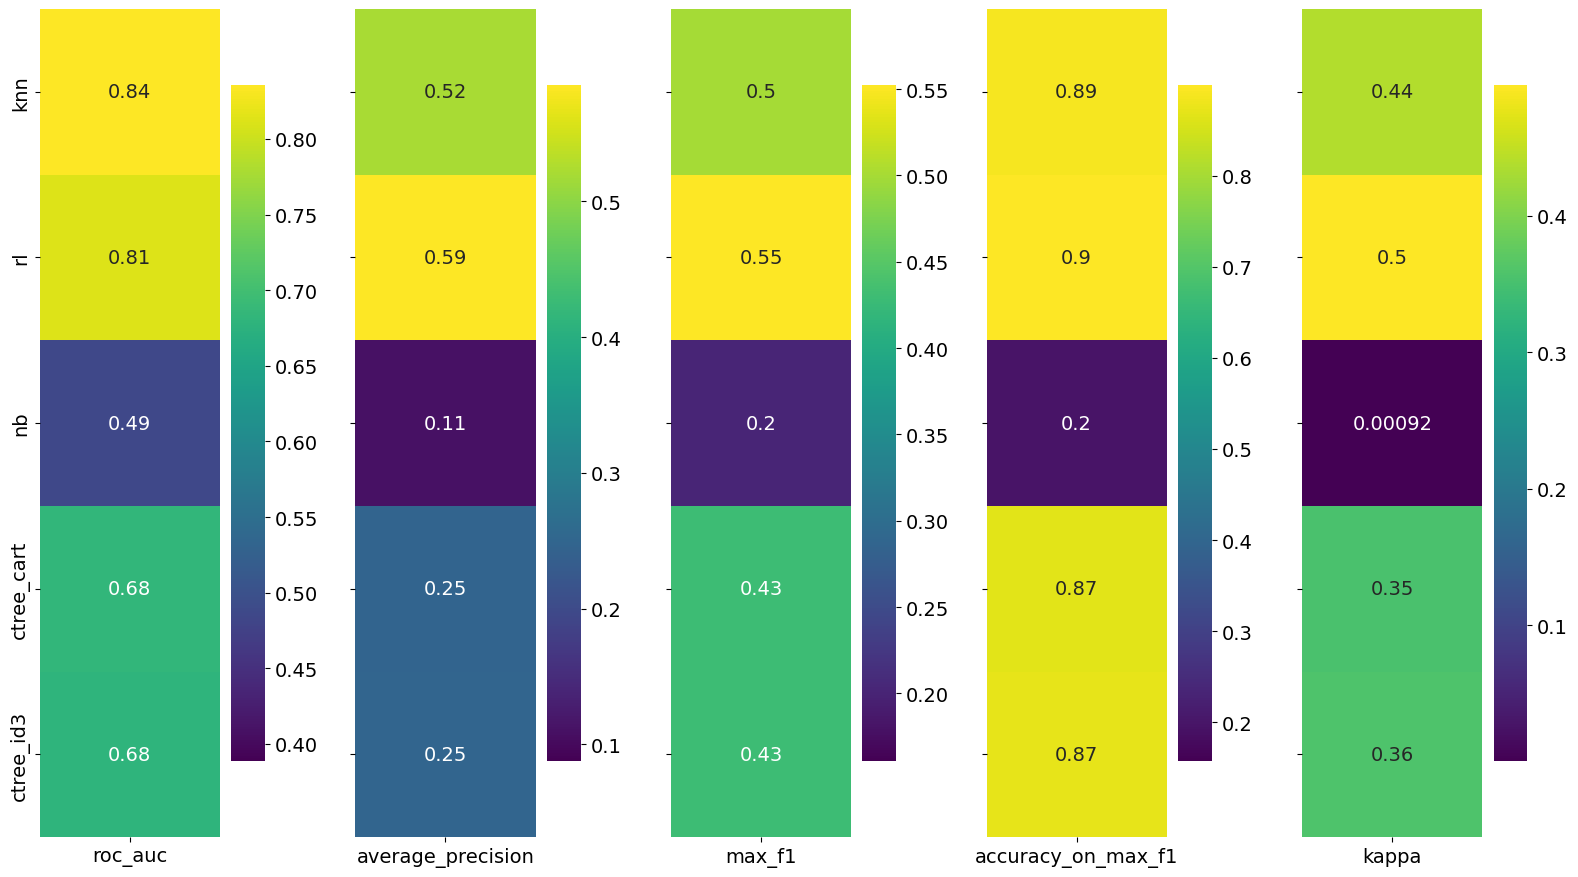

In [41]:
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)

fig, axs = plt.subplots(1, 5 , figsize=(16, 9), sharey=True)

for i, ax in enumerate(axs):
    sns.heatmap(
        df_metrics.iloc[:, [i]],
        ax=ax,
        vmin=df_metrics.iloc[:, [i]].min()*0.8,
        vmax=df_metrics.iloc[:, [i]].max(),
        annot=True,
        cmap='viridis'
    )

fig.tight_layout()

Definamos el umbral de decisión.

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

In [42]:
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([skm.f1_score(y_test, rl_val_preds>th) for th in ths])]
best_th

np.float64(0.20020020020020018)

Guardemos el modelo que más nos gustó.

In [43]:
with open("rl_pipeline.pkl", "wb") as f:
    pickle.dump(rl_pipeline, f)

Espera!! Deberiamos reentrenar con todos los datos?

In [44]:
start = time()
rl_pipeline.fit(X, y)
end = time()

print(
    'Tiempo Entrenamiento Regresión Logistica con todos los datos:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento Regresión Logistica con todos los datos: 0:00:00.076441


Ahora si, guardemos el mejor modelo hasta ahora

In [45]:
with open("rl_pipeline.pkl", "wb") as f:
    pickle.dump(rl_pipeline, f)

## Generar Submission

Realicemos predicciones sobre el test set de la competencia

In [46]:
test_df = pd.read_parquet("df_test.parquet")
test_df['EDAD_COMPLICACION'] = (test_df['Fecha_cero'] - test_df['FECHA_NACIMIENTO']).dt.days // 365

test_df[columnas_numerico] = X[columnas_numerico].astype(float)
test_df[columnas_categ] = X[columnas_categ].astype(str)

submission_pred = rl_pipeline.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_RL.csv", index=False)

In [47]:
submission#.Target.value_counts()

,ID,Target
0,4380,0
1,2998,0
2,6188,0
3,4966,0
4,1700,0
...,...,...
1690,2114,0
1691,5444,0
1692,1065,0
1693,3108,0
